In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import datetime as dt
import json

## 퀀트함수
from quant_functions import anal_funcs, data_funcs
import portfolio_obtimizer
import myfuncs
from fredapi import Fred
fred = Fred(api_key='cfb4f49f5c1a9396f671b8049d992e56')

# 시각화 관련
import plotly_express as px
import plotly.figure_factory as ff
import cufflinks as cf
cf.go_offline(connected=True)
## cf.getThemes()
cf.set_config_file(theme='polar')
import plotly.graph_objects as go
import seaborn as sns
sns.set_style('whitegrid')
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mticker
from matplotlib.ticker import LogLocator
import matplotlib.pyplot as plt
## figure size 설정
figsize=(12, 8)
plt.rcParams["figure.figsize"] = figsize
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

import graphModule as gm

## color 설정
with open('colors.json') as f:
    mycolors = json.load(f)

# 블루 테마
cmap_colors = ["#FFFFFF", mycolors['color_cont3'], mycolors['color_cont2']]
# LinearSegmentedColormap 생성
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", cmap_colors, N=256)    

## shock case
with open('shockCase.json', encoding='utf-8') as f:
    shock_cases = json.load(f)

## Data Load

In [2]:
## 보간용 필수 데이터
gold = pd.read_csv(f"gold.csv", encoding='utf-8').set_index('Date')[['Close']].rename(columns={'Close':'Gold'})
gold.index = pd.to_datetime(gold.index)
div = pd.read_csv(f"div.csv", encoding='utf-8').set_index('Date')[['Close']].rename(columns={'Close':'Div'})
div.index = pd.to_datetime(div.index)
ds20 = fred.get_series('DGS20')
ds10 = fred.get_series('DGS10')

## load data
df_ref = data_funcs.get_merged_df('^IXIC', '^GSPC', '^DJI', 'GC=F')
df_ref = df_ref.fillna(method = 'pad')
df_ref['Div'] = div['Div']
df_ref['Gold'] = gold['Gold']
df_ref['DGS10'] = ds10
df_ref['DGS20'] = ds20

## Imputation
df_ref = myfuncs.imputation(df_ref, '^GSPC', '^DJI')
df_ref = myfuncs.imputation(df_ref, '^DJI', 'Div')
df_ref = myfuncs.imputation(df_ref, 'DGS10', 'DGS20')
df_ref = myfuncs.imputation(df_ref, 'DGS20', 'DGS10')
df_ref = myfuncs.imputation(df_ref, 'GC=F', 'Gold')
df_ref['Gold']['1975-01-02'] = 1
df_ref['Gold']['1975-01-03'] = 1

## column selection
df_ref = df_ref[['^GSPC', '^DJI', '^IXIC', 'Div', 'DGS10', 'DGS20', 'Gold']]
df_ref.columns = ['S&P500', 'DowJones', 'NASDAQ', 'Div', 'DGS10', 'DGS20', 'Gold']

## 75년 이전에는 Gold 데이터가 없음
df_ref = df_ref['1975':]
df_ref = df_ref/df_ref.iloc[0]

[*********************100%%**********************]  4 of 4 completed


0.9188141405258731
0.8698779253276527
0.756654068113118
1.1913234894984643
0.9953424146502148


In [3]:
## 프로젝트마다 필요한 데이터
tickers = ['QQQ', 'QLD', 'TQQQ', 'TLT']
df_ori = data_funcs.get_merged_df(*tickers)
df_ori = df_ori[tickers]

[*********************100%%**********************]  4 of 4 completed


In [4]:
## 보간 시계열 데이터
df_imp = pd.concat([df_ref, df_ori], axis=1)
df_imp = myfuncs.imputation(df_imp, 'NASDAQ', 'QQQ')
df_imp = myfuncs.imputation(df_imp, 'QQQ', 'QLD')
df_imp = myfuncs.imputation(df_imp, 'QLD', 'TQQQ')
df_imp = myfuncs.imputation(df_imp, 'DGS20', 'TLT')

## 비보간 시계열 데이터
df_cut = df_imp[df_ori.dropna().index[0]:]
df_cut = df_cut/df_cut.iloc[0]

1.0447821465979674
1.9898640094390987
1.4885217366031023
-0.4195221954517219


In [5]:
highlight_periods = [(shock_cases['1차오일쇼크_t0'], shock_cases['1차오일쇼크_t1']),
                     (shock_cases['2차오일쇼크_t0'], shock_cases['2차오일쇼크_t1']),
                     (shock_cases['물가충격_t0'], shock_cases['물가충격_t1']),
                     (shock_cases['걸프전_t0'], shock_cases['걸프전_t1']),
                     (shock_cases['닷컴버블_t0'], shock_cases['닷컴버블_t1']),
                     (shock_cases['금융위기_t0'], shock_cases['금융위기_t1']),
                     (shock_cases['코로나_t0'], shock_cases['코로나_t1'])]

## Visualization

In [6]:
plot_df = df_imp.copy()
# plot_df = df_imp['1999':].copy()
# plot_df = df_imp['2010':].copy()
# plot_df = df_imp['2015':].copy()
# plot_df = df_cut[:]
plot_df = plot_df/plot_df.iloc[0]*100
# highlight_periods = [
#                      (shock_cases['코로나_t0'], shock_cases['코로나_t1'])]

# highlight_periods = [
#                      (shock_cases['금융위기_t0'], shock_cases['금융위기_t1']),
#                      (shock_cases['코로나_t0'], shock_cases['코로나_t1'])]

temp_df = plot_df[['QQQ', 'TQQQ', 'TLT', 'Gold']].copy()
temp_df['QQQ_Peak'] = temp_df['QQQ'].cummax()
temp_df['threshold'] = temp_df['QQQ_Peak']*0.75
temp_df['Drawdown'] = (temp_df['QQQ'] - temp_df['QQQ_Peak']) / temp_df['QQQ_Peak']

temp_df['Stage'] = 'S0'

s3_active = False
for i in temp_df.index:
    if temp_df.loc[i, 'Drawdown'] <= -.35:
        s3_active = True
    elif temp_df.loc[i, 'QQQ'] == temp_df.loc[i, 'QQQ_Peak']:
        s3_active = False

    if s3_active:
        temp_df.loc[i, 'Stage'] = 'S3'
    elif temp_df.loc[i, 'Drawdown'] <= -.25:
        temp_df.loc[i, 'Stage'] = 'S2'
    elif temp_df.loc[i, 'Drawdown'] <= -.15:
        temp_df.loc[i, 'Stage'] = 'S1'


# temp_df['Stage'] = temp_df['Drawdown'].apply(lambda x: 'S3' if x <= -.4 else 'S2' if x <= -.25 else 'S1' if x <= -.15 else 'S0')

temp_df['Stage'] = temp_df['Stage'].shift(0).fillna('S0')

# Stage에 따른 비중 설정
def set_ratios(stage):
    if stage == 'S1':
        return 0, 0.5, 0.25, 0.25
    elif stage == 'S2':
        return 0, 0.2, 0.4, 0.4
    elif stage == 'S3':
        return 0.5, 0, 0.25, 0.25
    else:
        return 0.5, 0, 0.25, 0.25

temp_df[['TQQQ_Ratio', 'QQQ_Ratio', 'TLT_Ratio', 'Gold_Ratio']] = temp_df['Stage'].apply(set_ratios).apply(pd.Series)

temp_df['Strategy'] = ((temp_df['TQQQ'].pct_change().fillna(0) * temp_df['TQQQ_Ratio'] + 
                        temp_df['QQQ'].pct_change().fillna(0) * temp_df['QQQ_Ratio'] + 
                        temp_df['TLT'].pct_change().fillna(0) * temp_df['TLT_Ratio'] + 
                        temp_df['Gold'].pct_change().fillna(0) * temp_df['Gold_Ratio'] )+1).cumprod()*100

In [11]:
assets = ['Strategy', 'TQQQ', 'QQQ']
assets_sp = ['Strategy']

In [12]:
plot_df = temp_df[assets]

In [13]:
anal_funcs.get_Vol_report(plot_df, "a")

,Return,Volatility,Volatility(Down),Residual,Beta,Sharpe_Ratio,Sortino_Ratio,Trainer_Ratio,Jensen_Alpha,Info_Ratio
Ticker,,,,,,,,,,
Strategy,30.68,8.68,5.47,0.00,1.00,3.30,5.25,28.68,-0.00,NaN
TQQQ,36.44,18.75,11.78,11.00,0.44,1.84,2.92,79.17,21.97,0.52
QQQ,13.40,6.27,4.70,3.54,1.30,1.82,2.42,8.78,-25.83,-4.88


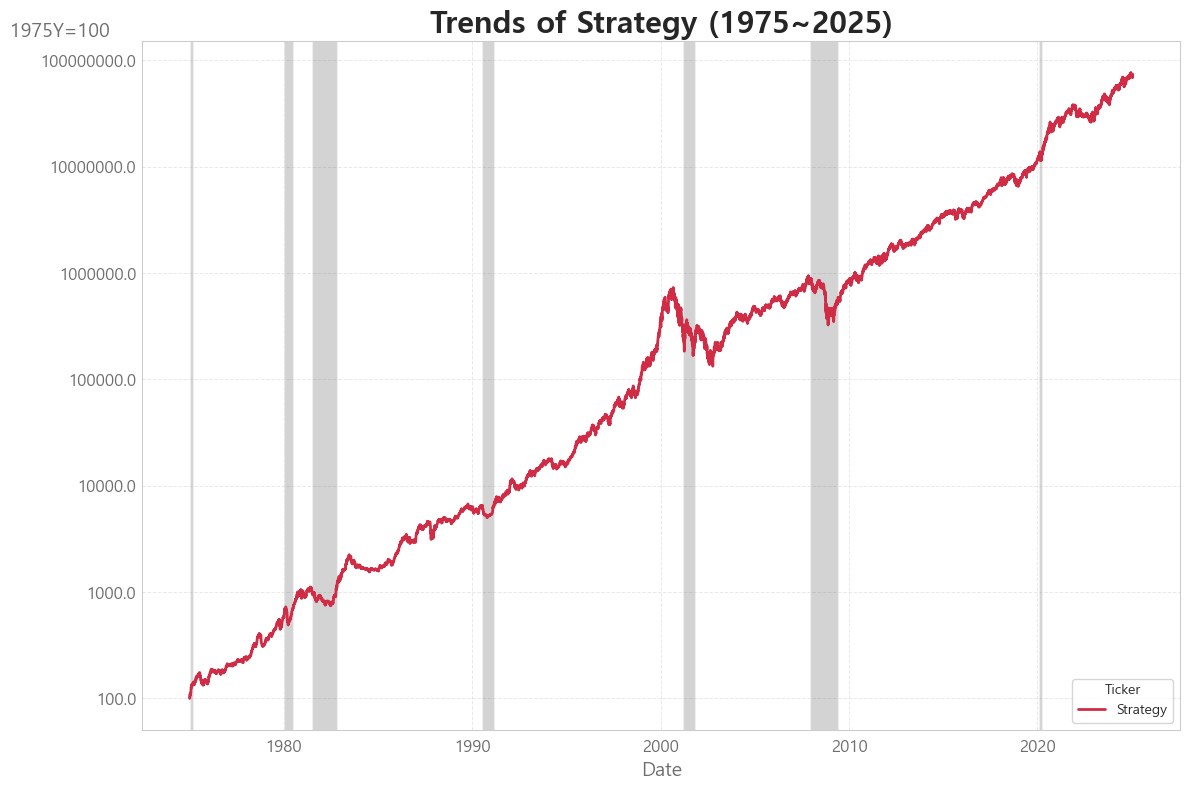

In [18]:
gm.trend_plot(plot_df, assets_sp, highlight_periods=highlight_periods, colors=[mycolors['color_norm'], mycolors['color_sub']])

In [12]:
gm.trend_plot(plot_df, assets, highlight_periods=highlight_periods, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])a

SyntaxError: invalid syntax (3461010612.py, line 1)

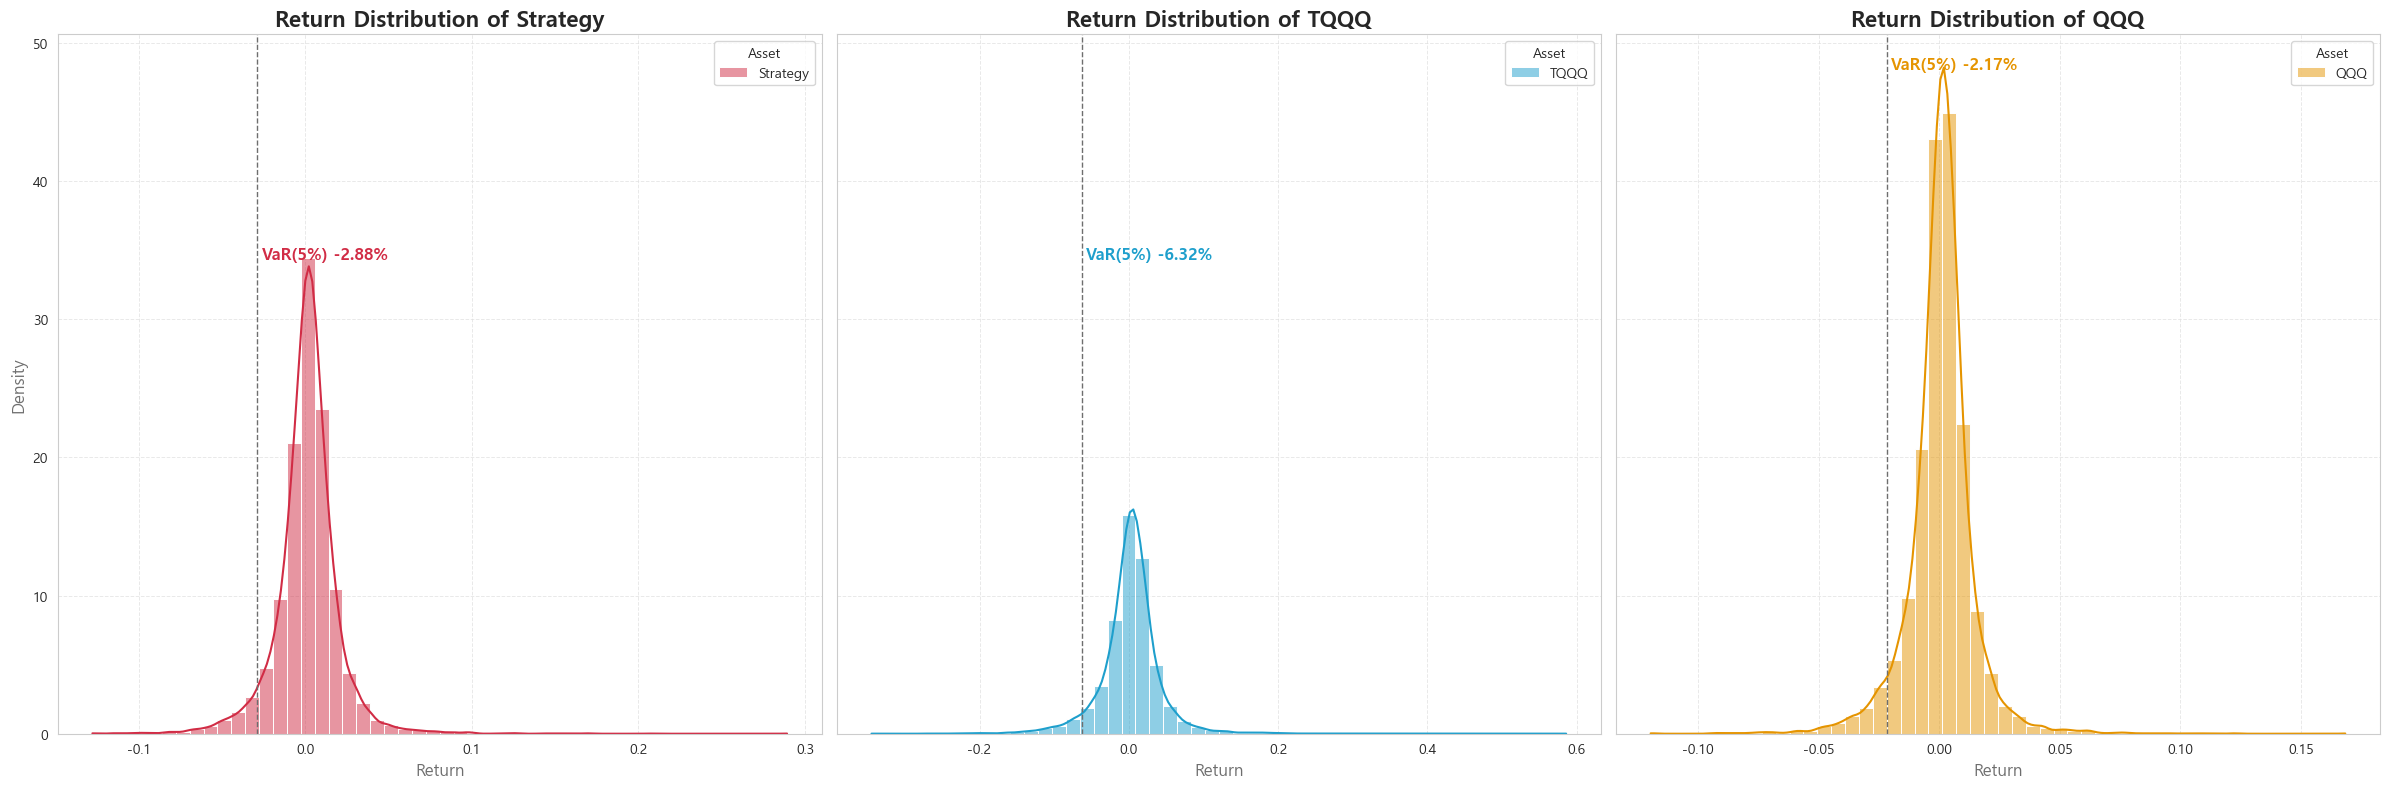

In [13]:
gm.asset_histogram_plot(plot_df.pct_change(), assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

In [14]:
## gm.asset_histogram_merged_plot(plot_df.pct_change(), assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

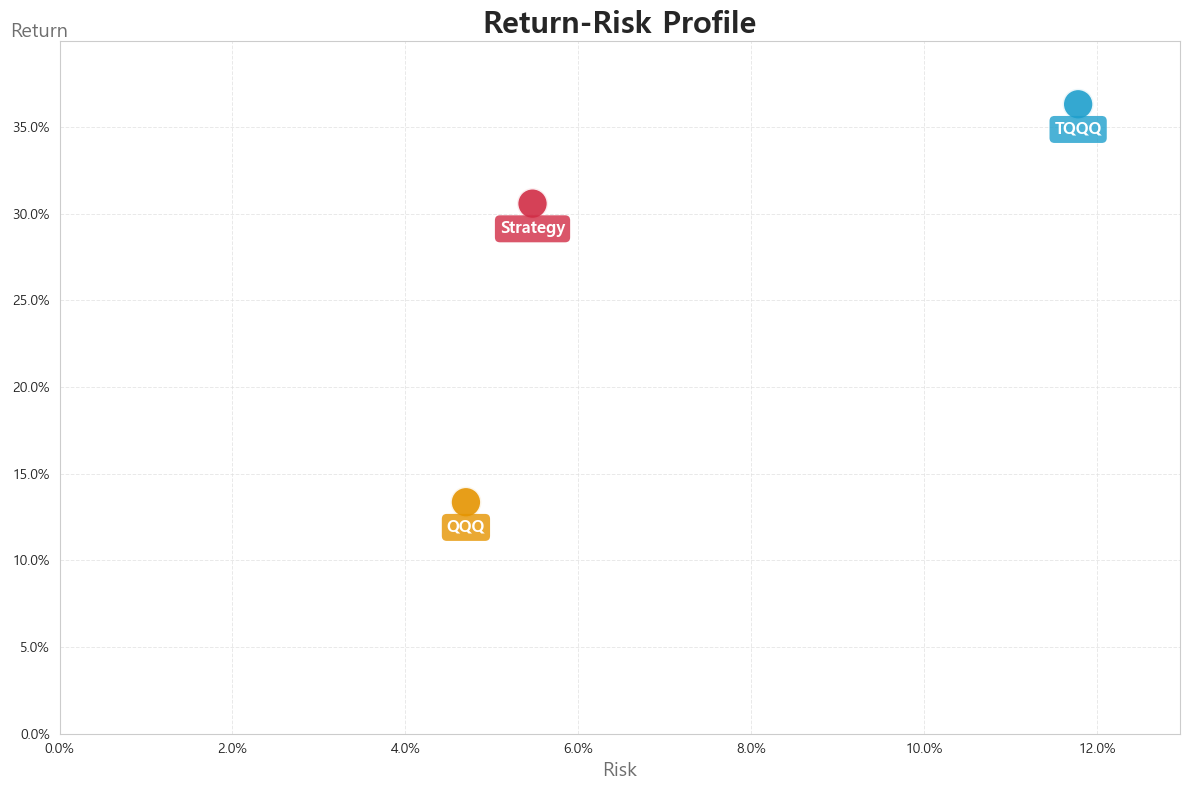

In [15]:
return_risk_df = anal_funcs.get_Vol_report(plot_df[assets], method='a', rf=0)
gm.return_risk_profile_plot(return_risk_df, assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])
# gm.return_risk_profile_plot(return_risk_df, assets, colors=[mycolors['color_norm'], mycolors['color_cont']])

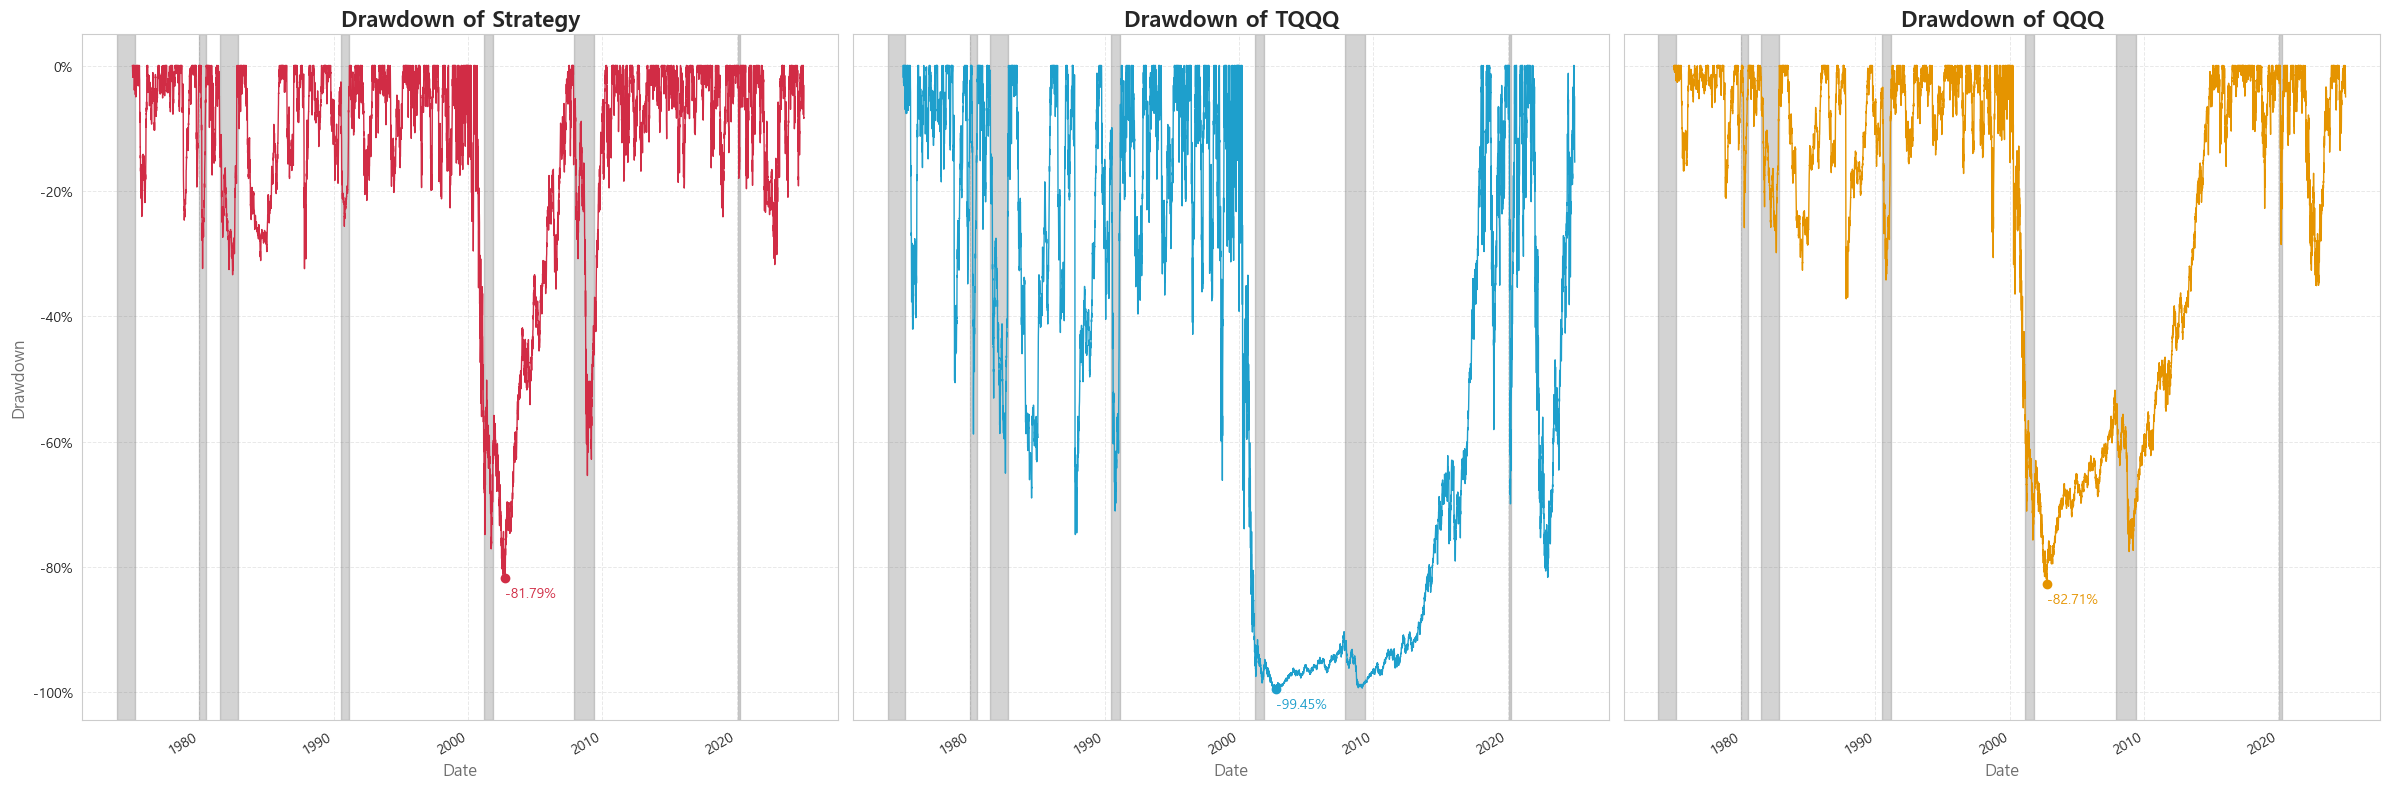

In [16]:
gm.drawdown_plot(plot_df, assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']], highlight_periods=highlight_periods)

In [17]:
ttr_df = myfuncs.get_ttr_df(plot_df, assets)

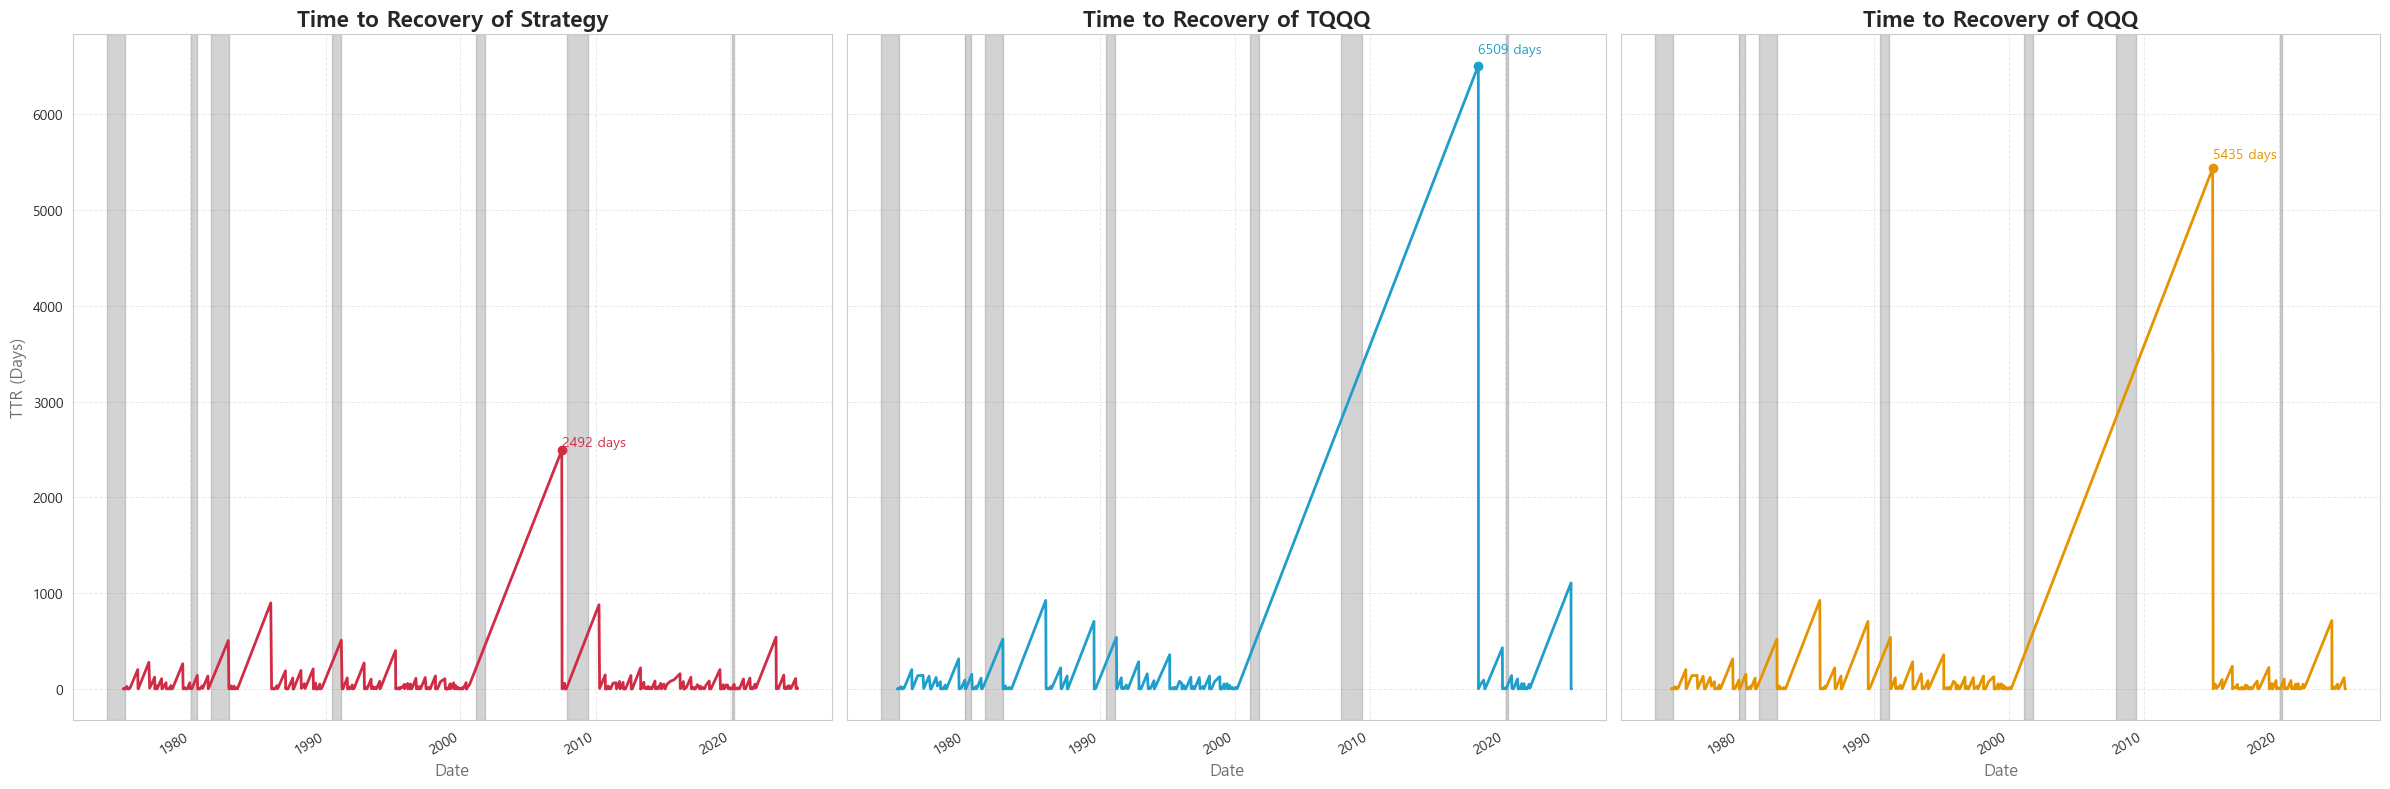

In [18]:
ttr_df = myfuncs.get_ttr_df(plot_df, assets)

gm.ttr_plot(ttr_df, assets, highlight_periods=highlight_periods, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

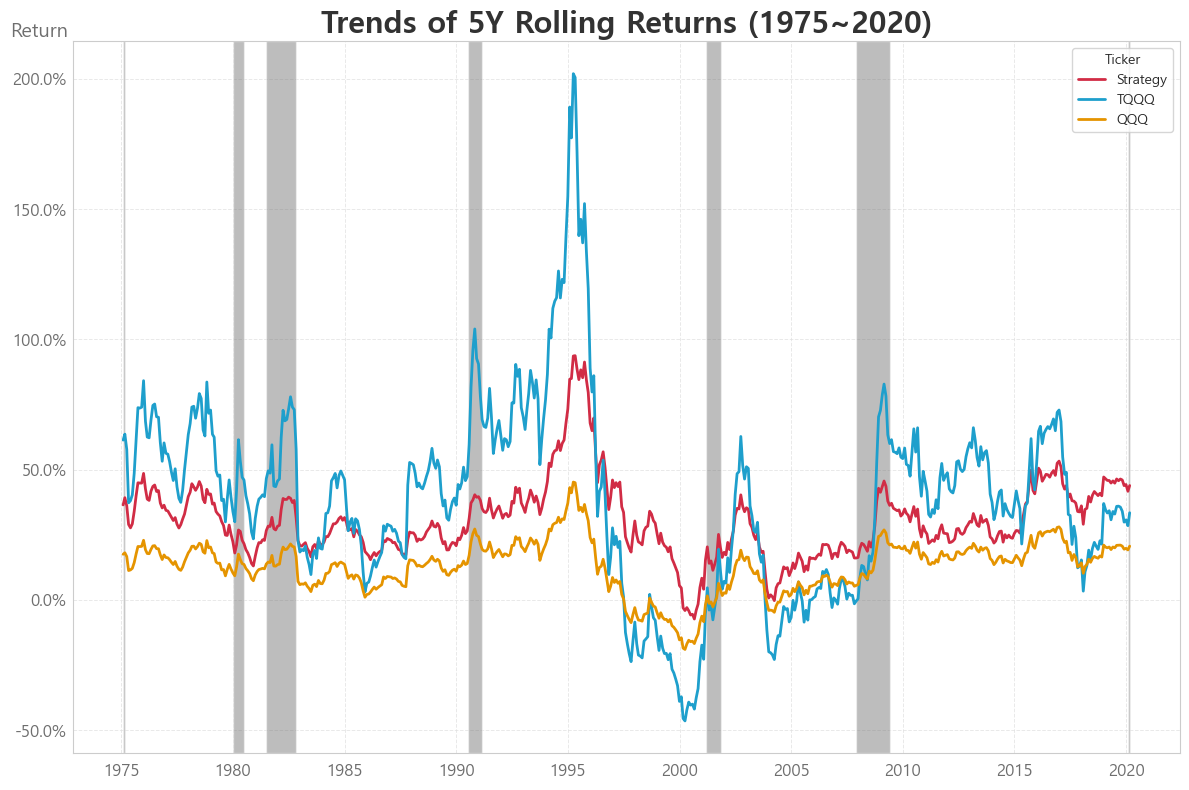

In [19]:
rr_df = myfuncs.get_rr_df(plot_df, assets)
gm.rr_trend_plot(rr_df, assets, highlight_periods=highlight_periods, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

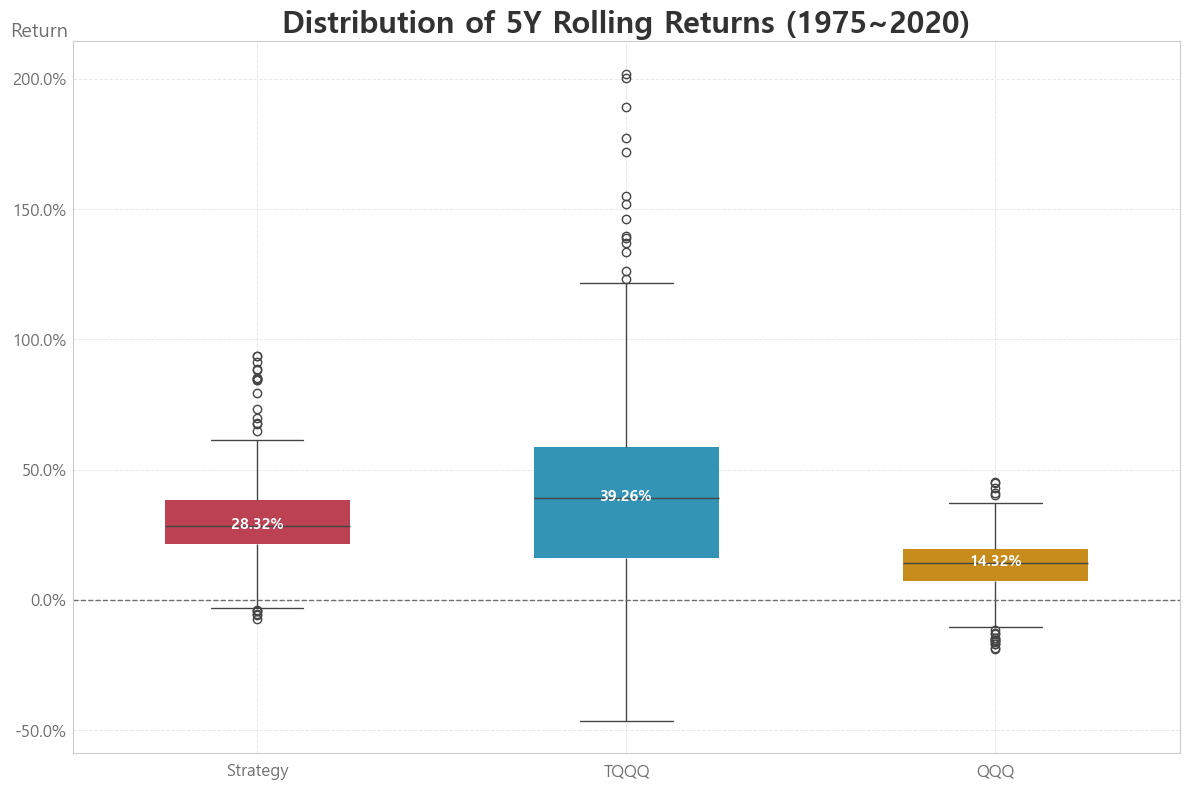

In [20]:
gm.rr_box_plot(rr_df, assets, colors=[mycolors['color_norm'], mycolors['color_cont'], mycolors['color_sub']])

In [1162]:
assets_port = assets + ['TLT', 'Gold']
assets_port = ['TQQQ','QQQ']

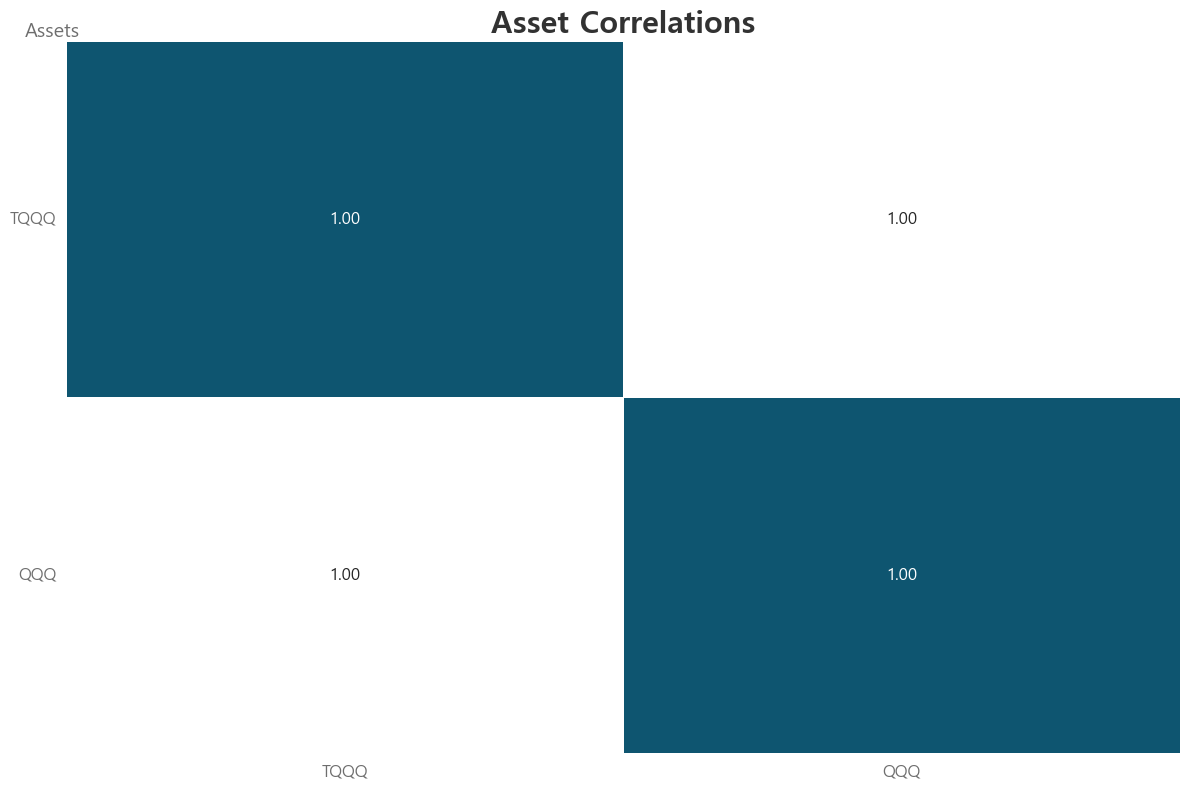

In [1064]:
corr_df = plot_df.pct_change()[assets_port].corr()
gm.corr_plot(corr_df, cmap=custom_cmap)